# Topic of the Opensource Project : Object Detection using MobileNet v2 SSD (SSDlite)
> 
> This Notebook covers training an Object detection network using SSDLite on Indian Vehicle Number Plate dataset downloaded from [Kaggle](https://https://www.kaggle.com/dataturks/vehicle-number-plate-detection)

> # Step 1_a. 
> > Environment Setup and Dataset acquisition followed by pre-processing.

In [1]:
#Checking the configuration of the run-time
!nvidia-smi

Wed Mar  3 06:28:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#importing modules
import numpy as np
import tensorflow.keras as keras
from keras.layers import Conv2D, BatchNormalization, Add,MaxPool2D, ZeroPadding2D,DepthwiseConv2D, ReLU, Input,AveragePooling2D, GlobalAveragePooling2D,Dense, Activation
from keras.activations import sigmoid,relu
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential,Model
from keras.preprocessing.image import load_img,array_to_img, img_to_array, ImageDataGenerator
import os
import pandas as pd
from PIL import Image
import urllib
import tqdm
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [3]:
#loading the dataset via Google drive
Path = '/content/drive/MyDrive/Colab Notebooks/Dataset'
os.chdir(Path)
!ls

 ALPR_Checkpoint    fruits_dataset.zip	        Test2.jpg   train_zip
 apple_2.jpg	    Indian_Number_plates.json   Test3.jpg
 checkpoint	    Test1.jpg		        Test4.jpg
 FruitDetector.h5  'Test2 (1).jpg'	        test_zip


In [4]:
#reading json file using pandas
df = pd.read_json('Indian_Number_plates.json', lines=True)

In [5]:
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [6]:
#printing the head and keys of the dataset
print(df.head())
print(df.keys())
#clearly we can see that the dataframe has 3 keys known as 'content' which is the URL of the image, 'annotation which contains the ROI of bbx' and 'extras' being the metadata
print(df['content'])

                                             content  ... extras
0  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
1  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
2  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
3  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
4  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN

[5 rows x 3 columns]
Index(['content', 'annotation', 'extras'], dtype='object')
0      http://com.dataturks.a96-i23.open.s3.amazonaws...
1      http://com.dataturks.a96-i23.open.s3.amazonaws...
2      http://com.dataturks.a96-i23.open.s3.amazonaws...
3      http://com.dataturks.a96-i23.open.s3.amazonaws...
4      http://com.dataturks.a96-i23.open.s3.amazonaws...
                             ...                        
232    http://com.dataturks.a96-i23.open.s3.amazonaws...
233    http://com.dataturks.a96-i23.open.s3.amazonaws...
234    http://com.dataturks.a96-i23.open.s3.amazonaws...
235    http://co

In [7]:
def process_create_train_val_set(dataframe):
  #create a dictionary for the dataset i.e Image_data, xmin, ymin, xmax, ymax, class_id
  Images, coordinates = [],[]
  #Now iterating through the rows in the dataframe
  image_counter=0
  #Assuming each of the links in the dataframe are working
  for index, sample in tqdm.tqdm_notebook(dataframe.iterrows()):
    image = urllib.request.urlopen(sample['content'])
    #now opening the image and converting it to 3 channel RGB
    image = Image.open(image)
    image = image.convert('RGB')
    #capturing the original dimensions of the image for coordinate scaling at a later stage
    w,h,_ = np.shape(image)
    image_data = image.resize((224,224))
    #converting the image to array
    image_data = img_to_array(image_data)
    #appending this data in the dictionary
    Images.append(image_data)
    #till this point, we have our image data
    #fetching x min, xmax, ymin and ymax from annotation key of the above dataframe
    Coordinates = sample['annotation']
    #Appending normalized coordinates as per the new aspect ratio of resized image
    #print(int(round(Coordinates[0]['points'][1]['x']*1*(224))))
    x1 = int(round(Coordinates[0]['points'][0]['x']*224))
    y1= int(round((Coordinates[0]['points'][0]['y']*224)))
    x2 = (int(round((Coordinates[0]['points'][1]['x']*224))))
    y2 = (int(round((Coordinates[0]['points'][1]['y']*224))))
    coordinates.append([x1,y1,x2-x1,y2-y1])
    #incrementing the counter by 1
    image_counter+=1
  return Images,coordinates
  #return((Dataset['Image_data']))

#running the main function
Images,coordinates = process_create_train_val_set(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [12]:
#checking the length of each list
print(np.shape(Images))
print(np.shape(coordinates))

(237, 224, 224, 3)
(237, 4)


# Data Validation Stage
 > In this Stage, We will monitor the resized images and their bounding box coordinates by plotting few random samples from the dataset.

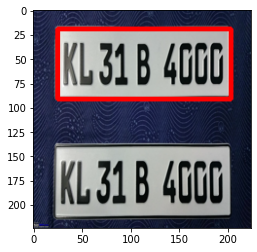

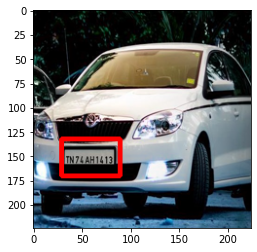

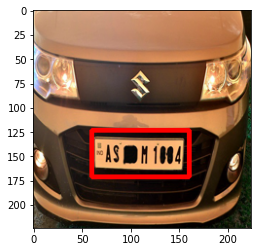

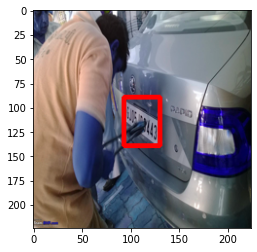

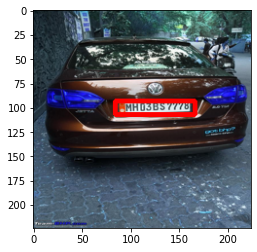

In [13]:
def plot_annotated_image(Images, coordinates):
  #generate 5_random indices
  idx=[]
  for i in range(5):
    idx.append(random.randint(1,30))
  #now plot these random images
  for id in idx:
    #converting array to image.
    image = np.array(array_to_img(Images[id]))
    #converting rgb image to bgr
    im_arr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #print((Dataset['xmin'][id],Dataset['ymin'][id]),(Dataset['xmax'][id],Dataset['ymax'][id]))
    #Drawing bounding box
    cv2.rectangle(im_arr,(coordinates[id][0],coordinates[id][1],coordinates[id][2],coordinates[id][3]),(255,0,0), 3)
    #displaying the image with bounding box
    plt.imshow(im_arr)
    plt.show()
plot_annotated_image(Images,coordinates)

# Analysis result
> - We can observe that our coordinates and images are proper, now we can move towards the final step of Data processing pipeline i.e train and val split of the dataset

In [14]:
#creating split as 70-30% ratio
train_image,val_image,train_coordinates,val_coordinates = train_test_split(Images,coordinates,test_size=0.3, shuffle=True)

In [15]:
#converting each list to numpy array
train_image = np.asarray(train_image)
val_image = np.asarray(val_image)
train_coordinates = np.asarray(train_coordinates)
val_coordinates = np.asarray(val_coordinates)

print("Number of training image samples",np.shape(train_image))
print("Number of training coordinate samples",np.shape(train_coordinates))
print("Number of validation image samples",np.shape(val_image))
print("Number of validation coordinate samples",np.shape(val_coordinates))



Number of training image samples (165, 224, 224, 3)
Number of training coordinate samples (165, 4)
Number of validation image samples (72, 224, 224, 3)
Number of validation coordinate samples (72, 4)


Train Split Images


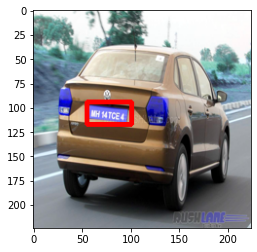

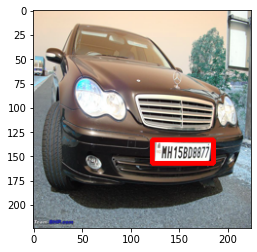

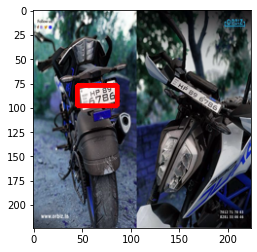

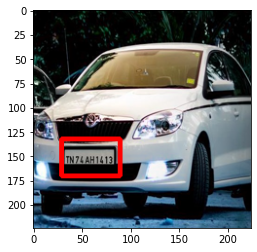

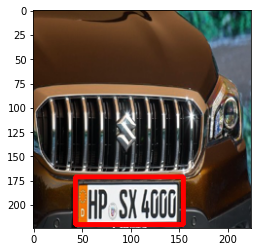

Val Split Images


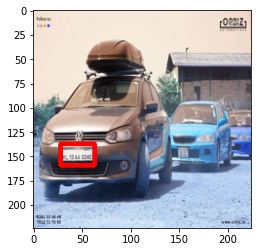

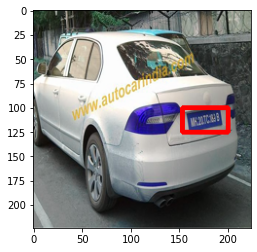

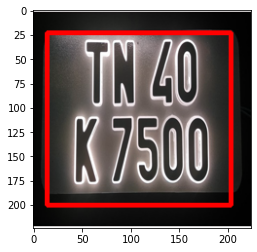

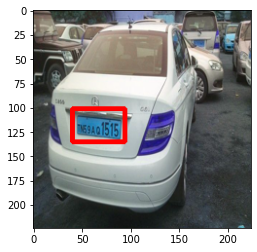

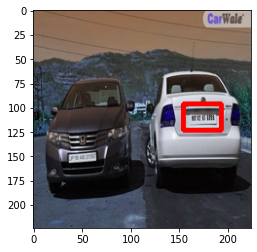

In [16]:
#validating splitted train and test data

print("Train Split Images")
plot_annotated_image(train_image, train_coordinates)
print("Val Split Images")
plot_annotated_image(val_image, val_coordinates)

# Step 1.b
Using Data generators

In [17]:
print(df.head())
df = df.sample(frac = 1)
print(df.head())

                                             content  ... extras
0  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
1  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
2  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
3  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
4  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN

[5 rows x 3 columns]
                                               content  ... extras
58   http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
159  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
116  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
93   http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
155  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN

[5 rows x 3 columns]


In [ ]:
#shuffling the dataframe
# def shuffle(dataframe_samples):
#   return dataframe_samples.sample(frac=1)

#This is slow as it gives url error
# # A data generator loads data in batches and yields the images and their corresponding labels(annotations and class_labels)
# def html_based_generator(samples, batch_size = 32):
#     #samples = dataframe out here
#     num_samples = len(samples)
#     #endlessly iterate the generator
#     while True:
#       #shuffling the samples
#       shuffle(samples)
#       for mini_batch in range(0, num_samples,batch_size):
#           batch_samples = samples[mini_batch:mini_batch+batch_size]
#           #Initialise empty list for I/0 of network, here Image, labels and coordniates
#           Images, coordinates,labels = [],[],[]
#           for image_url, bbox in zip(batch_samples['content'], batch_samples['annotation']):
#             #load image and append them in Images
#             image = urllib.request.urlopen(image_url)
#             #now opening the image and converting it to 3 channel RGB
#             image = Image.open(image)
#             image = image.convert('RGB')
#             #capturing the original dimensions of the image for coordinate scaling at a later stage
#             w,h,_ = np.shape(image)
#             image_data = image.resize((224,224))
#             #converting the image to array
#             image_data = img_to_array(image_data)
#             #appending this data in the dictionary
#             Images.append(image_data)
#             #load the coordinates and append them in Coordinates]
#             #Appending normalized coordinates as per the new aspect ratio of resized image
#             #print(int(round(Coordinates[0]['points'][1]['x']*1*(224))))
#             x1 = int(round(bbox[0]['points'][0]['x']*224))
#             y1= int(round((bbox[0]['points'][0]['y']*224)))
#             x2 = (int(round((bbox[0]['points'][1]['x']*224))))
#             y2 = (int(round((bbox[0]['points'][1]['y']*224))))
#             coordinates.append([x1,y1,x2-x1,y2-y1])
#             #load the labels and append them in Labels
#             #since this is only single class statement
#             labels.append(0)
        
#           #convert each list to numpy arrays to ensure that they get processed by fit function
#           Images = np.asarray(Images)
#           coordinates = np.asarray(coordinates)
#           labels = np.asarray(labels)
#           #yeild the generator array objects

#           yield Images,coordinates,labels

#shuffle function for lists
def shuffle_data(images,coordinates):
  c = list(zip(images, coordinates))
  images, coordinates = random.shuffle(c)
  return images,coordinates

# better version of data generator with data samples which takes in images and coordinates instead of dataframes
def generator(images,coordinates, batch_size = 32):
    #samples = list of images and coordinates; assuming them to have equal number of images
    num_samples = len(images)
    #endlessly iterate the generator
    while True:
      #shuffling the samples
      #images,coordinates = shuffle_data(images,coordinates)
      for image_mini_batch, coordinates_mini_batch in zip(range(0, num_samples,batch_size),range(0, num_samples,batch_size)):
          image_batch_samples = images[image_mini_batch:image_mini_batch+batch_size]
          coordinate_batch_samples = coordinates[coordinates_mini_batch:coordinates_mini_batch+batch_size]
          #Initialise empty list for I/0 of network, here Image, labels and coordniates
          Images, coordinates,labels = [],[],[]
          for image, bbox in zip(image_batch_samples, coordinate_batch_samples):
            #append them to Images directly
            Images.append(image)
            #load the coordinates and append them in Coordinates]
            #Appending normalized coordinates as per the new aspect ratio of resized image
            #print(int(round(Coordinates[0]['points'][1]['x']*1*(224))))
            coordinates.append(bbox)
            #label = 0 so not changing
            
        
          #convert each list to numpy arrays to ensure that they get processed by fit function
          Images = np.asarray(Images)
          coordinates = np.asarray(coordinates)
          labels = np.asarray(labels)
          #yeild the generator array objects

          yield Images,coordinates




#testing datagenerator
train_generator = generator(Images,coordinates)

In [9]:
#checking the data given by image generator
idx=0
for image,coordinate in train_generator:
    #plotting for 2 cycles of data generator
    if idx<=2:
      try:
        plot_annotated_image(image, coordinate)
      except IndexError:
        print("Skipping")
      idx+=1

NameError: ignored

### Outcome
Great, we have our image data generator also working!

#Conclusion of Data Engineering 
> Till this point our data is perfectly segmented into train and val split along with 6 indices storing image_data, 4 coordinates and class_id
> Also in part 2, we have made our image data generator to work pretty fine too.

## Step2_a
> > Deep Learning Network Architecture (Mobilenet V2 SSD from scratch)

In [18]:
def SSDLite(input_shape, coordinates):
  #bottleneck block
  #bottle neck block
  def bottleneck_block(input_tensor, squeezed_filters, alpha=1.0, expansion_factor=6, stride = 1):
    print("input shape", np.shape(input_tensor))
    in_channels = np.shape(input_tensor)[-1]
    out = Conv2D(expansion_factor * in_channels, (1,1))(input_tensor)
    out = BatchNormalization()(out)
    out = ReLU(max_value=6)(out)
    if stride ==2:
      out = ZeroPadding2D(padding=(1,1))(out)
    out = DepthwiseConv2D((3,3))(out)
    out = BatchNormalization()(out)
    out = ReLU(max_value=6)(out)
    squeezed_filters = int(squeezed_filters * alpha)
    out = Conv2D(squeezed_filters, (1,1), padding='same')(out)
    out = BatchNormalization()(out)
    #hacky fix below :(
    out = ZeroPadding2D(padding=(1,1))(out)
    print("output shape", np.shape(out))
    if in_channels == squeezed_filters and stride ==1:
      output= Add()([out, input_tensor])
      return output
    return out
    
  Model_input = Input(input_shape)
  x = Conv2D(32,3,2,padding='same')(Model_input)
  #Batch normalisation and ReLU activation after each convolution are mandatory for non-linearity and avoiding co-variance shift
  x = BatchNormalization()(x)
  x = ReLU(max_value=6)(x)
  #now stacking depthwise conv block as per Mobilenet paper
  x = bottleneck_block(x,16,expansion_factor=1)
  # As n = 2
  x = bottleneck_block(x,24, stride=2)
  x = bottleneck_block(x,24, stride=1)
  # as n =3
  for _ in range(3):
    x = bottleneck_block(x,32,stride=1)
  # as n = 4
  for _ in range(4):
    x = bottleneck_block(x,64, stride =1)
  # as n = 3
  for _ in range(3):
    x = bottleneck_block(x,96, stride=1)
  # n =3
  for _ in range(3):
    x = bottleneck_block(x,160,stride=1)
  # as n = 1
  x = bottleneck_block(x,320, stride =1)
  # as n = 1
  x = Conv2D(1280, (1,1))(x)
  x = BatchNormalization()(x)
  x = ReLU(max_value=6)(x)
  #Adding average pooling 2D layer
  x = GlobalAveragePooling2D()(x)
  # full connected i.e dense layer
  bbox = Dense(coordinates, activation='linear', name="regressor")(x)
  model = Model(Model_input, bbox)
  return model

In [19]:
Input_shape = 224,224,3
num_classes = 1
coordinates = 4
model = SSDLite(Input_shape,coordinates)
model.summary()

input shape (None, 112, 112, 32)
output shape (None, 112, 112, 16)
input shape (None, 112, 112, 16)
output shape (None, 114, 114, 24)
input shape (None, 114, 114, 24)
output shape (None, 114, 114, 24)
input shape (None, 114, 114, 24)
output shape (None, 114, 114, 32)
input shape (None, 114, 114, 32)
output shape (None, 114, 114, 32)
input shape (None, 114, 114, 32)
output shape (None, 114, 114, 32)
input shape (None, 114, 114, 32)
output shape (None, 114, 114, 64)
input shape (None, 114, 114, 64)
output shape (None, 114, 114, 64)
input shape (None, 114, 114, 64)
output shape (None, 114, 114, 64)
input shape (None, 114, 114, 64)
output shape (None, 114, 114, 64)
input shape (None, 114, 114, 64)
output shape (None, 114, 114, 96)
input shape (None, 114, 114, 96)
output shape (None, 114, 114, 96)
input shape (None, 114, 114, 96)
output shape (None, 114, 114, 96)
input shape (None, 114, 114, 96)
output shape (None, 114, 114, 160)
input shape (None, 114, 114, 160)
output shape (None, 114, 11

In [20]:
#compiling model with loss functions
init_lr = 0.1
epochs = 20
opt =RMSprop(lr=0.1, decay=0.9, momentum=0.9)
model.compile(optimizer=opt, 
              loss={'regressor':'mse'}, 
              metrics={'regressor':'accuracy'})

In [21]:
# training without generators
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Dataset/ALPR_Checkpoint", monitor='val_loss')]
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_image,train_coordinates,batch_size = 4,epochs = 100,verbose=1,callbacks=[callbacks], validation_data=(val_image, val_coordinates),shuffle=True, validation_batch_size=32 ,use_multiprocessing=True,workers=12 )

Epoch 1/100
42/42 [==============================] - 90s 1s/step - loss: 7558.2624 - accuracy: 0.5408 - val_loss: 23306308.0000 - val_accuracy: 0.6250
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Dataset/ALPR_Checkpoint/assets
Epoch 2/100
42/42 [==============================] - 42s 996ms/step - loss: 1647.6993 - accuracy: 0.5923 - val_loss: 22233252.0000 - val_accuracy: 0.6250
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Dataset/ALPR_Checkpoint/assets
Epoch 3/100
42/42 [==============================] - 42s 993ms/step - loss: 1501.9463 - accuracy: 0.7084 - val_loss: 19490246.0000 - val_accuracy: 0.6250
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Dataset/ALPR_Checkpoint/assets
Epoch 4/100
42/42 [==============================] - 42s 995ms/step - loss: 1512.6967 - accuracy: 0.6368 - val_loss: 7355780.0000 - val_accuracy: 0.6250
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks

In [22]:
#saving the model
model.save("NumberPlateDetector.h5")

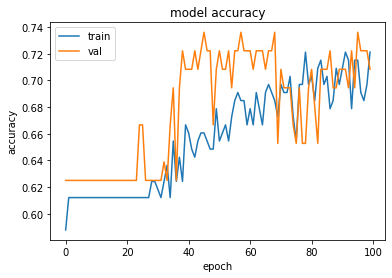

In [24]:
#plotting the model loss plot and accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

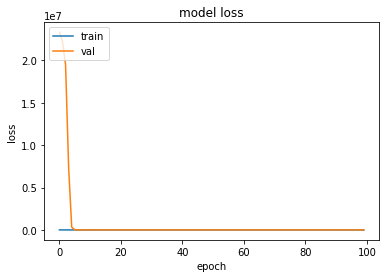

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2. Inference Stage

In [36]:
from google.colab import files
uploaded = files.upload()

Saving LicensePlate3.jpg to LicensePlate3.jpg
Saving LicensePlate.jpg to LicensePlate (1).jpg


LicensePlate.jpg
LicensePlate3.jpg


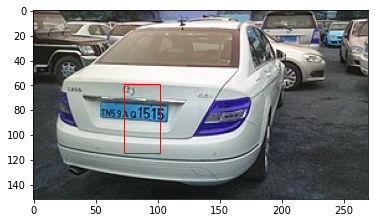

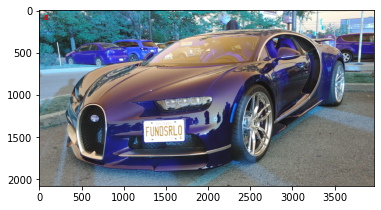

In [37]:
import matplotlib.patches as patches
#evaluation on unseen image samples from https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.reddit.com%2Fr%2Fpics%2Fcomments%2F953d61%2Foc_came_across_a_bugatti_chiron_on_my_way_home%2F&psig=AOvVaw3cnpQ9IzKFFipoiIiI3gDk&ust=1614846028336000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCNDuwrbYk-8CFQAAAAAdAAAAABAD

image_list = []
image_list.append('LicensePlate.jpg')
image_list.append('LicensePlate3.jpg')

for orig_image in image_list:
  print(orig_image)
  orig_image = cv2.imread(orig_image)
  image = cv2.resize(orig_image,(224,224),interpolation = cv2.INTER_AREA)
  image = np.reshape(image,(1,224,224,3))
  #np.shape(image))
  out_tensor = model.predict(image)
  #classlabel is by default number plate
  #print(out_tensor[0][0])
  xA,yA,xB,yB= out_tensor[0]
  #visualising
  fig,ax = plt.subplots()
  #fig.suptitle("Predicted Labe, fontsize=10)
  ax.imshow(orig_image)
  rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
  ax.add_patch(rect)

# Observation:
Clearly since the cars in the dataset are not Indian so it failed to predict the bounding box on bugatti. Let's try on Indian car samples also

In [38]:
from google.colab import files
uploaded = files.upload()

Saving LicensePlate4.jpg to LicensePlate4.jpg
Saving LicensePlate2.jpg to LicensePlate2.jpg


LicensePlate2.jpg
LicensePlate4.jpg


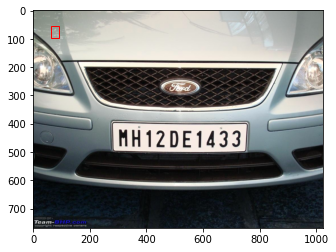

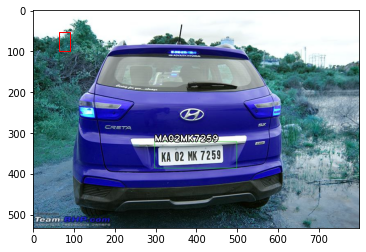

In [39]:
import matplotlib.patches as patches
#evaluation on unseen image samples from https://www.google.com/search?q=indian+car+license+plate&tbm=isch&ved=2ahUKEwjo1-_p2JPvAhWdnUsFHS_JCU4Q2-cCegQIABAA&oq=indian+car+license+plate&gs_lcp=CgNpbWcQAzICCAAyCAgAEAgQBxAeUMCKBFjajQRgopAEaABwAHgAgAHxAYgBzAaSAQUwLjIuMpgBAKABAaoBC2d3cy13aXotaW1nwAEB&sclient=img&ei=REc_YOilOp27rtoPr5Kn8AQ&bih=735&biw=1536#imgrc=-rRNcu9VioHTEM
image_list = []
image_list.append('LicensePlate2.jpg')
image_list.append('LicensePlate4.jpg')

for orig_image in image_list:
  print(orig_image)
  orig_image = cv2.imread(orig_image)
  image = cv2.resize(orig_image,(224,224),interpolation = cv2.INTER_AREA)
  image = np.reshape(image,(1,224,224,3))
  #np.shape(image))
  out_tensor = model.predict(image)
  #classlabel is by default number plate
  #print(out_tensor[0][0])
  xA,yA,xB,yB= out_tensor[0]
  #visualising
  fig,ax = plt.subplots()
  #fig.suptitle("Predicted Labe, fontsize=10)
  ax.imshow(orig_image)
  rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
  ax.add_patch(rect)

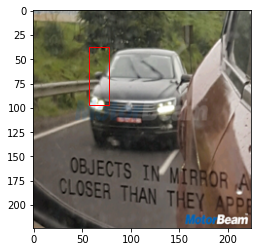

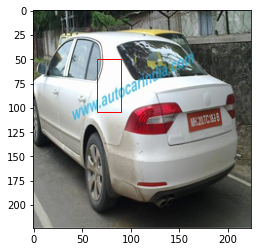

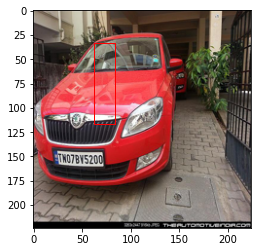

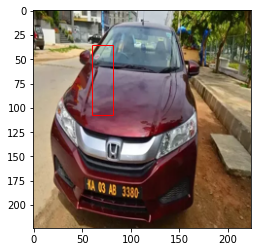

In [44]:
#let's try on val set samples, train_set_samples
image_list = [val_image[0], val_image[5], train_image[1], train_image[63]]
for orig_image in image_list:
  orig_image = array_to_img(orig_image)
  #image = cv2.resize(orig_image,(224,224),interpolation = cv2.INTER_AREA)
  image = np.reshape(orig_image,(1,224,224,3))
  #np.shape(image))
  out_tensor = model.predict(image)
  #classlabel is by default number plate
  #print(out_tensor[0][0])
  xA,yA,xB,yB= out_tensor[0]
  #visualising
  fig,ax = plt.subplots()
  #fig.suptitle("Predicted Labe, fontsize=10)
  ax.imshow(orig_image)
  rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
  ax.add_patch(rect)

# Conclusion till this Point 
Model's accuracy is not at all great in this POC model designed from scratch and obviously due to the fact that we directly tried to regress the bbox coordinates instead of Anchor Boxes !

# Next Steps
We'll add the Anchor box + NMS functionality to our model and improve its accuracy(Hopefully) in our next trial